In [6]:
# Import relevant packages for analysis
import stan as ps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from patsy import dmatrix, dmatrices
from patsy.contrasts import Treatment, Sum
import arviz as az

# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply();

# Bayesian estimation equivalent of the Mixed ANOVA

# Bayesian inference
<font size = "3"> Following the quick description of the classic Mixed ANOVA above its important to keep in mind that Bayesian inference is derived from the application of Bayes rule $P(\theta \mid y) = \large \frac{P(y \mid \theta) \, P(\theta)}{P(y)}$ and as such while the following description of the Bayesian model is an equivalent to the one-way ANOVA, it is fundamentally different, because it uses fully probabilistic modelling and the inferences are not based on sampling distributions.</font>
    
<font size = "1"> For a fuller description see the Practicing Bayesian statistics markdown file within the Github repository.</font>

# Steps of Bayesian data analysis

<font size = "3"> Kruschke (2015) offers a step by step formulation for how to conduct a Bayesian data analysis:

1. Identify the relevant data for the question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. If a scientific research publication is the goal, the priors must be accepted by a skeptical audience. This can be achieved by using prior predictive checks to ascertain if the priors are reasonable.

4. Using Bayes rule, estimate the posterior for the model parameters using the likelihood and priors. Then use the posterior to conduct your inference.

5. Conduct model checks. i.e. Posterior predictive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

#  Step 1 - Identify the relevant data for question under investigation

## Data overview and study description

The data analysed here have been taken from https://drive.google.com/file/d/0Bz-rhZ21ShvOdlBZZTRON3JQZ2s/view?resourcekey=0-c7XpYRHR3gpMYGbYcerM4g, and stored in the Github repository for these notebooks for ease of import. The dataset is originally fromexperiment 3 of Zhang et al. (2014). See the original paper here https://journals.sagepub.com/stoken/default+domain/2CauuvIqpaIUiIdXSWh4/full.

The practice of keeping a diary is a practice that certain people engage. The purpose of keeping a diary vary across people. A common reason for individuals to keep a diary, is to remember and contemplate their life events. 
A result of this is that when people reread their diaries they often gain further insights and understandign of the life events they record and the associated emotions.

The data analysed here from Zhang et al. 2014 was aimed to investigate how individuals would predict their own reactions to ordinary vs extraordinary events. The researchers predicted that individuals would underestimate their curiosity when looking back at ordinary life event but more accurate when predicting future curiosity to extraoridnary events.

In order to investigate these types of predictions the researchers individuals who were currently in romantic relationships and ask half of them to write a diary entry about valentines (extraordinary) day and the other half to write about and ordinary day with their romantic partners. Participants then had to rate extraordinariness for this diary entry. The participants were then ask to predict how they would view their written description in the future. This was measured as a composite enjoyment score.

All the participants where then contacted again and asked to read their diary entry and rate the extrordinariness in retrospect.

## Import data

In [7]:
# Import dataset for Mixed ANOVA from associated Github for this notebook
url = 'https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/Zhang%20et%20al.%202014%20Study%203.csv'
df = pd.read_csv(url)

In [8]:
# Clauate the means for each variable split by the extraordinary and ordianry diary conditions.
means = df.groupby(by = 'Condition').mean()
# Output the means to check if the Condition 
means['T1_Extraordinariness']

Condition
1    2.734375
2    4.348485
Name: T1_Extraordinariness, dtype: float64

In [9]:
df.insert(0, 'ParticipantID', range(0, len(df)))
df['ParticipantID'] = df['ParticipantID'] + 1

Work out the melt for mixed desing

In [10]:
df_long = pd.melt(df, id_vars = ['ParticipantID', 'Condition'],
                  value_vars = ['T1_Extraordinariness', 'T2_Extraordinariness'],
                  var_name = 'Time', value_name = 'Composite')
df_long['Condition'] = df_long.Condition.astype('category')
df_long['Time'] = df_long.Time.astype('category')

In [11]:
X = np.asarray(dmatrix(' ~ Condition * Time', data = df_long))

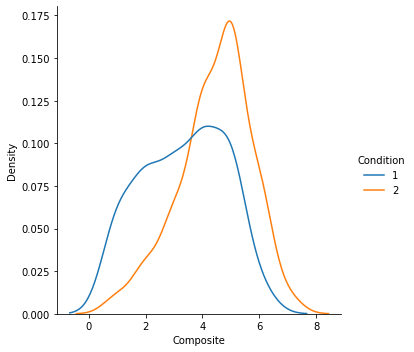

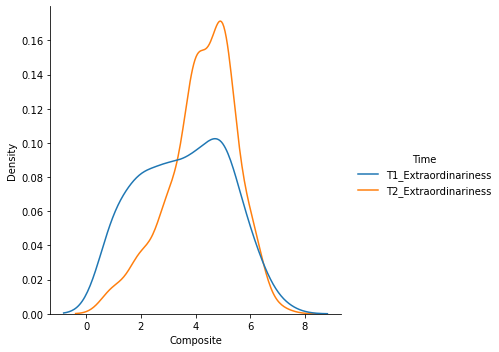

In [54]:
sns.displot(data = df_long, x = "Composite", hue = "Condition", kind="kde");
sns.displot(data = df_long, x = "Composite", hue = "Time", kind="kde");

In [40]:
MixedANOVA = '''
data{
int<lower=1> N; // number of data observed
int<lower=1> J; // number of subjects
int<lower=1> K; // Number of predictors
matrix[N,K] X; // Design matrix
vector[N] y; // Dependent variable
int<lower = 0, upper=J> subj_id[N];

// Prior values

}
parameters{
vector[K] beta;
vector[J] z_u;
real<lower = 0> sigma;
real<lower=0> sigma_u;
}

transformed parameters{
vector[J] u;
vector[N] mu;

u = z_u * sigma_u;
mu = u[subj_id] + X * beta;
}

model{
// Priors
beta ~ normal(0, 10);
sigma ~  normal(0, 10);
sigma_u ~ normal(0, 10);
z_u ~ std_normal();

y ~ normal(mu, sigma);

}
generated quantities{
real yrep[N];
yrep = normal_rng(mu, sigma);

}
'''

In [41]:
# Generate python dictionary to pass to Pystan. 
data = {'N': len(df_long),
        'J': len(np.unique(df_long['ParticipantID'])),
        'K': np.shape(X)[1],
        'X': X,
        'y': df_long['Composite'].values,
        'subj_id': df_long['ParticipantID'].values
                  }

In [42]:
sm = ps.build(MixedANOVA, data = data)

Building...



Building: 43.0s, done.

In [48]:
fit = sm.sample(num_chains = 4, num_samples = 1000, num_warmup = 1000, stepsize = 1 )

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   1% (101/8000)
Sampling:   4% (301/8000)
Sampling:   8% (601/8000)
Sampling:  19% (1500/8000)
Sampling:  42% (3400/8000)
Sampling:  65% (5200/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!


In [49]:
az.summary(fit, var_names = ['beta', 'u', 'sigma', 'sigma_u'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],2.734,0.163,2.438,3.047,0.004,0.003,1866.0,2517.0,1.0
beta[1],1.614,0.228,1.200,2.044,0.005,0.004,1805.0,2608.0,1.0
beta[2],1.202,0.191,0.845,1.569,0.004,0.003,2363.0,2879.0,1.0
beta[3],-1.032,0.267,-1.519,-0.515,0.005,0.004,2483.0,2855.0,1.0
u[0],-0.155,0.531,-1.152,0.847,0.007,0.009,5965.0,2686.0,1.0
...,...,...,...,...,...,...,...,...,...
u[127],0.259,0.533,-0.714,1.269,0.007,0.008,6243.0,2822.0,1.0
u[128],-0.421,0.532,-1.400,0.586,0.007,0.007,5993.0,3253.0,1.0
u[129],0.492,0.531,-0.443,1.554,0.008,0.007,4982.0,2920.0,1.0
sigma,1.094,0.070,0.969,1.231,0.002,0.001,1260.0,1817.0,1.0


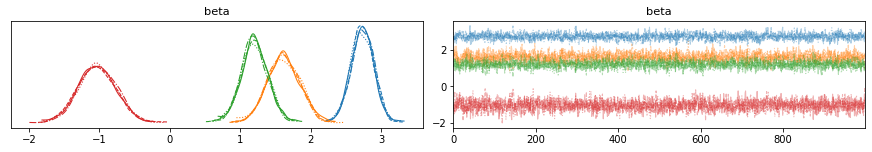

In [50]:
az.plot_trace(fit, var_names = ['beta']);

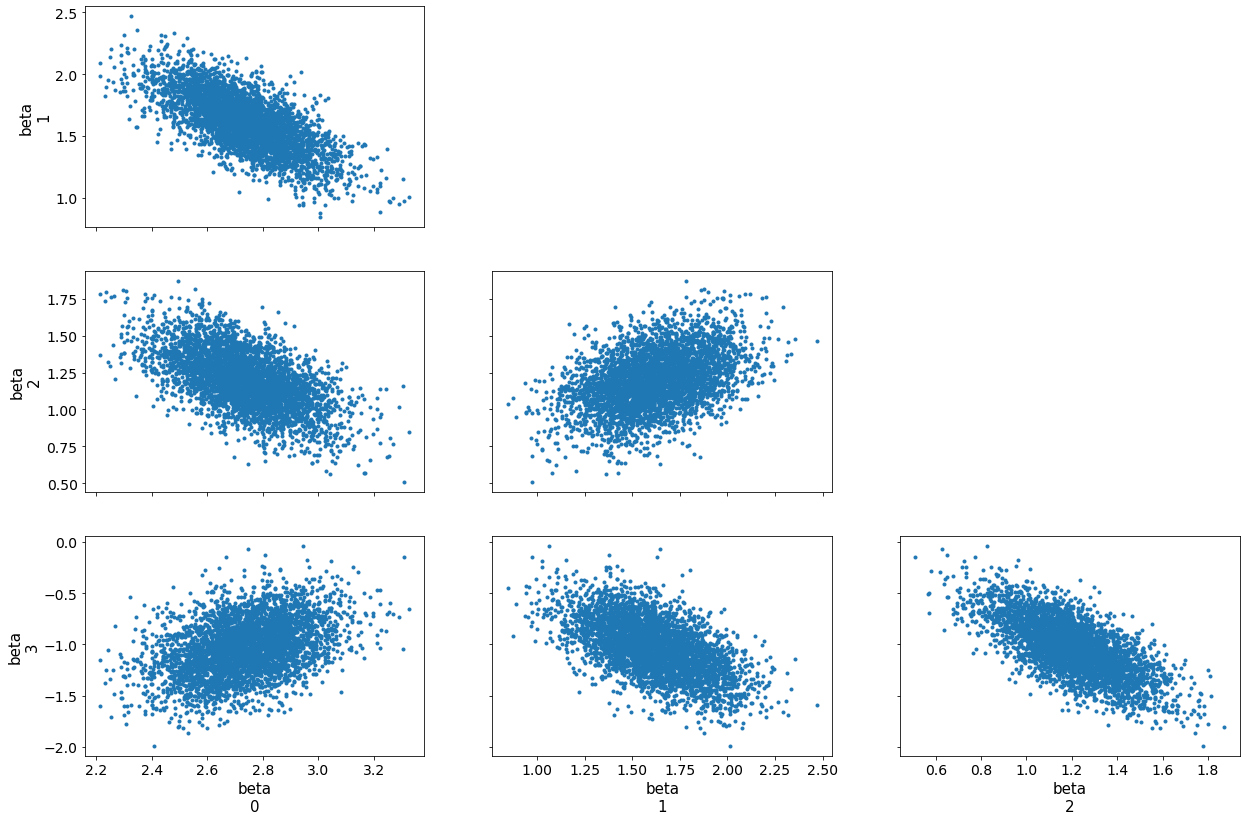

In [55]:
az.plot_pair(fit, var_names = ['beta']);

# References

Gabry, J., Simpson, D., Vehtari, A., Betancourt, M., & Gelman, A. (2019). Visualization in Bayesian workflow. Journal of the Royal Statistical Society: Series A (Statistics in Society), 182(2), 389-402.

Kruschke, J. (2015). Doing Bayesian data analysis: A tutorial with R, JAGS and Stan. Oxford, England: Academic Press.    
    
McElreath, R. (2020). Statistical rethinking: A Bayesian course with examples in R and Stan.Boca Raton: CRC Press.

Zhang, T., Kim, T., Brooks, A. W., Gino, F., & Norton, M. I. (2014). A "present" for the future: The
unexpected value of rediscovery. Psychological Science, 25, 1851-1860.